**Classification of Agroclimates in Semi Arid Plains**

In [28]:
# Import Modules

# Data handling modules
import matplotlib as plt
import pandas as pd
import numpy as np
import geopandas as gpd #reference for Geopandas https://geopandas.org/mapping.html 

# Statistic modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cluster modules
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE, MDS
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans

# Plotting modules
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Clip geoframe
from shapely.geometry import box
from fiona.crs import from_epsg

**Load data pre-processed data stored on Github**

In [12]:
# load feature data
URL = 'C:/Users/sarahann.USERS/Desktop/code/crop_rotation/feature_data.csv'
features = pd.read_csv(URL)
features=features.set_index('geometry') #geometry is maintained as the index for use in merging to map polygons after classification 

# domain experts recommend not including ph due to variability in space and time
features = features.drop(columns=['ph', 'silttotal_r']) 
features=features.rename(columns={'sandtotal_r':'sand', 'claytotal_r':'clay', 'hzdept_r':'depth', 'wsatiated_r':'H20_capcity'})
names=features.columns # obtain names of the features

# print a description of the data
round(features.describe(),2)

,elevation,vap_pres,precip,sand,clay,depth,H20_capcity,gdu
count,37750.00,37750.00,37750.00,37750.00,37750.00,37750.00,37750.00,37750.00
mean,1015.72,19.21,527.79,39.98,23.61,44.53,41.11,1903.05
std,433.79,3.09,128.70,20.08,7.86,11.57,3.53,328.53
min,238.00,8.00,286.00,3.83,0.94,4.66,5.22,277.00
25%,656.00,17.00,427.00,24.02,19.25,37.55,39.09,1638.00
50%,996.00,19.00,499.00,38.49,23.48,43.35,40.91,1916.00
75%,1299.00,22.00,619.00,53.40,27.58,50.74,43.67,2138.00
max,3509.00,28.00,945.00,93.97,44.53,84.77,48.81,2606.00


# Standardize the Data </br>

Data Description. The features of Kansas agroclimates in this feature set are elevation, vapor pressure, precipitation, % of sand, % of clay, depth of soil horizon and growing degree units in the months of April to September. </br>

The data is standardized with Sklearn StandardScale, z-score normalization, to account for the various units and scales of each represpective data set. 

In [13]:
scaler= StandardScaler()
X= scaler.fit_transform(features)

# Are all the features descriptive attributes of the agroclimate zones? Are any features correlated? 

We will explore the data in a couple ways</br> 1) a PCA graph </br>2) a coorelation matrix 

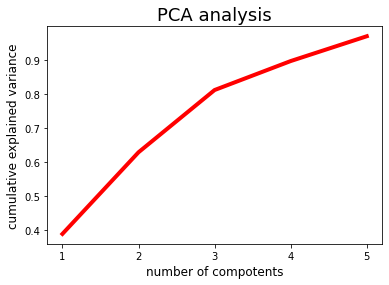

In [14]:
# Let's evaluate how many components are descriptive of 95% of the variability
pca=PCA(.95).fit(X) 
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=4, color='red')
plt.xlabel('number of compotents',  fontsize=12)
plt.ylabel('cumulative explained variance', fontsize=12)

plt.xticks([0,1,2,3,4],['1','2','3','4','5'])
plt.title('PCA analysis', fontsize=18)
plt.show()

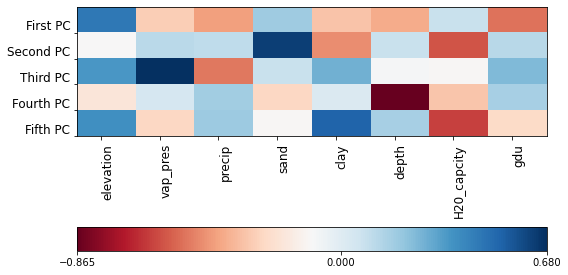

In [15]:
# Plot a matrix of the PCA compotents 
fig = plt.figure(figsize=(8, 4))

plt.imshow(pca.components_, interpolation = 'none', cmap = 'RdBu', aspect='auto')
feature_names = names

plt.gca().set_xticks(np.arange(-.1, 7));
plt.gca().set_yticks(np.arange(0.5, 5));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC','Third PC', 'Fourth PC', 'Fifth PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.35);

fig.tight_layout()
plt.show()

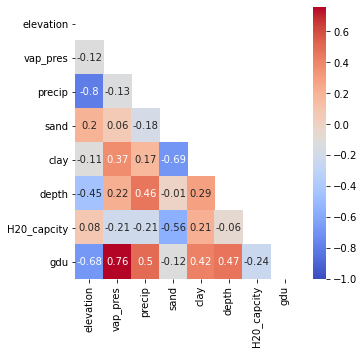

In [17]:
# Correlation Matrix
X_cor=pd.DataFrame(X, columns=names) # convert back to a pandas for use of corr() function
correlation = X_cor.corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(5,5))
sns.heatmap(round(X_cor.corr(),2),
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask=mask);

In [18]:
# We have coorelation in the data, and our PCA chart shows that 95% of our desciptive ability is in 5 compontents

# We will use PCA to transform our data to a PCA with five compotents 
print('Orginal Data Shape with all Features')
print(X.shape)

# Transform Data
pca=PCA(.95).fit(X)
X=pca.transform(X) 
print('Data shape after PCA with all Features')
print(X.shape)

Orginal Data Shape with all Features
(37750, 8)
Data shape after PCA with all Features
(37750, 5)


# How many clusters are optimal to divide the data? 
The metrics of silhouette and calinski harabasz score are used to evaluate performance of the clusters, in terms of inter and intra cluster density and dispersion. 

Silhouette score is used to determine similar an observation is to its assigned cluster relative to other clusters. The score is a mean measurement of all samples and a score of 1 with a bottom range of -1.  

Calinski harabasz is a variance ratio used to measure how similar a cluster is compared compared to the seperation of other clusters. This measure is a sum, and higher numbers indicate better performance. 

These score will be used to evaluate the clustering algorithums of KMeans, gaussian mixture model, and select the ideal number of clusters.

In [19]:
# KMeans
print ('Performance of Kmeans models with different clusters')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    clusters = KMeans(n_clusters)            
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans models with different clusters
For 2 clusters silhouette score is: 0.4 and the calinski harabasz score is: 14168.49
For 3 clusters silhouette score is: 0.37 and the calinski harabasz score is: 13539.45
For 4 clusters silhouette score is: 0.44 and the calinski harabasz score is: 14266.36
For 5 clusters silhouette score is: 0.45 and the calinski harabasz score is: 14598.65
For 6 clusters silhouette score is: 0.46 and the calinski harabasz score is: 14359.09
For 7 clusters silhouette score is: 0.49 and the calinski harabasz score is: 14217.95
For 8 clusters silhouette score is: 0.48 and the calinski harabasz score is: 13805.16
For 9 clusters silhouette score is: 0.44 and the calinski harabasz score is: 13254.44
For 10 clusters silhouette score is: 0.45 and the calinski harabasz score is: 12873.38


In [20]:
#GMM
print ('Performance of GMM models with different clusters')
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    clusters = clusterer = GMM(n_components=n_clusters, covariance_type='spherical')  # tied and spherical covariance significantly improve model        
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of GMM models with different clusters
For 2 clusters silhouette score is: 0.4 and the calinski harabasz score is: 13679.41
For 3 clusters silhouette score is: 0.35 and the calinski harabasz score is: 13017.02
For 4 clusters silhouette score is: 0.4 and the calinski harabasz score is: 13778.53
For 5 clusters silhouette score is: 0.43 and the calinski harabasz score is: 14095.14
For 6 clusters silhouette score is: 0.45 and the calinski harabasz score is: 14131.48
For 7 clusters silhouette score is: 0.46 and the calinski harabasz score is: 13440.13
For 8 clusters silhouette score is: 0.47 and the calinski harabasz score is: 12570.61
For 9 clusters silhouette score is: 0.38 and the calinski harabasz score is: 11530.51
For 10 clusters silhouette score is: 0.44 and the calinski harabasz score is: 12145.68


## Further evaluate cluster number for the GMM model
It looks like three clusters are ideal. We have an additional tool to evaluate the optimal number of clusters for the Gaussian Mixed Model. The Akaike (preferences more complex models) and Bayesian Information Criterion (penalizes complex models) elbow plot bends at 3 clusters, which aligns with the performance metrics of silhouette and calinski harabasz.  

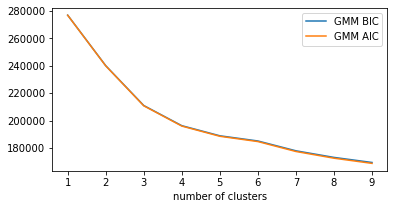

In [32]:
# Evaluate number of clusters for GMM, the elbow plot supports 3 clusters
bic_list = []
aic_list = []

ranges = range(1,10)
for i in ranges:
    gmm = GMM(n_components=i, covariance_type='spherical').fit(X)
    
    # BIC
    bic = gmm.bic(X)
    bic_list.append(bic)

    # AIC
    aic = gmm.aic(X)
    aic_list.append(aic)

plt.figure(figsize=(6, 3))
plt.plot(ranges, bic_list, label='GMM BIC');
plt.plot(ranges, aic_list, label='GMM AIC');
plt.xlabel('number of clusters')
plt.legend(loc='best');

## What if we didn't use a linear PCA process to transform our data? 
PCA analysis assumes the data is linearly seperable. Here we use two alternative approaches to reduce dimensionality in the data. The t-distributed stochastic neighbor embedding (t-SNE) preserves local neighbors, where the multidimensional scaling (MDS) minimizes the input and output spaces while preserving the ranking of distances between the spaces. Both approaches rebalance the reduction of dimensionality with preservation of groups/clusters in the observations. 

In [23]:
# Do a t-SNE tranformation
X_non_pca= scaler.fit_transform(features) #start with a scaled feature set
tsne = TSNE() # default is 2 for n_components
X_tsne= tsne.fit_transform(X_non_pca) 

In [49]:
print('Orginal Data Shape',features.shape)
print('Data shape after t-SNE transformation', X_tsne.shape)
print('Data shape after MDS transformation', X_mds.shape)

Orginal Data Shape (12190, 8)
Data shape after t-SNE transformation (12190, 2)
Data shape after MDS transformation (12190, 2)


In [50]:
# Evaluate performance of models with t-SNE transformation 
# KMeans
print ('Performance of Kmeans models with different clusters with t-SNE')
range_n_clusters = [5, 6, 7, 8, 9, 10, 11, 12, 13]
for n_clusters in range_n_clusters:
    clusters = KMeans(n_clusters)            
    cluster_labels = clusters.fit_predict(X_tsne)
    silhouette_avg = silhouette_score(X_tsne, cluster_labels, metric='sqeuclidean')
    silhouette_avg = silhouette_score(X_tsne, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X_tsne, cluster_labels)
    print("For", n_clusters, "clusters",
          "average silhouette:", round(silhouette_avg,2),
          "calinski harabasz:", round(CHS_avg,2))
    
#GMM
print ('Performance of GMM models with different clusters with t-SNE')
range_n_clusters = [5, 6, 7, 8, 9, 10, 11, 12, 13]
for n_clusters in range_n_clusters:
    clusters = clusterer = GMM(n_components=n_clusters, covariance_type='spherical')  # tied and spherical covariance significantly improve model        
    cluster_labels = clusters.fit_predict(X_tsne)
    silhouette_avg = silhouette_score(X_tsne, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X_tsne, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans models with different clusters with t-SNE
For 5 clusters average silhouette: 0.55 calinski harabasz: 11036.8
For 6 clusters average silhouette: 0.56 calinski harabasz: 11014.21
For 7 clusters average silhouette: 0.54 calinski harabasz: 11011.74
For 8 clusters average silhouette: 0.53 calinski harabasz: 11328.33
For 9 clusters average silhouette: 0.53 calinski harabasz: 11395.78
For 10 clusters average silhouette: 0.54 calinski harabasz: 11626.02
For 11 clusters average silhouette: 0.55 calinski harabasz: 11901.09
For 12 clusters average silhouette: 0.57 calinski harabasz: 12196.01
For 13 clusters average silhouette: 0.56 calinski harabasz: 12293.06
Performance of GMM models with different clusters with t-SNE
For 5 clusters silhouette score is: 0.55 and the calinski harabasz score is: 10884.79
For 6 clusters silhouette score is: 0.52 and the calinski harabasz score is: 10669.6
For 7 clusters silhouette score is: 0.52 and the calinski harabasz score is: 10744.16
For

# What do the various clusters look like? 
Here we merge the cluster prediction back to the georeferenced map of Kansas. 

In [30]:
# Shape file of area
states = ['Kansas', 'Texas', 'Oklahoma', 'Colorado', 'Nebraska']

#County boundaries
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp'#'C:/code/files/code/us_county/US_County_Boundaries.shp' # county file
map_df = gpd.read_file(fp)
map_df['NAME']= map_df['NAME'].str.replace(' ','') 
map_df=(map_df[map_df.NAME.isin(states)])          
map_df=map_df.to_crs(epsg=4269) 
map_df.crs

# Code to set a box to clip the map region 
minx, miny = -105, 32.5 # coordinates for the overall boundaries
maxx, maxy = -98, 42

bbox = box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4269)) 
geo = geo.to_crs(crs=map_df.crs)

plains=gpd.overlay(geo, map_df, how='identity') 

# shape file of feature data
map_df = gpd.read_file('C:/Users/sarahann.USERS/Desktop/code/crop_rotation/feature_data.shape') 
map_df= map_df.set_axis(['elevation', 'vap_pres', 'precip', 'sand', 'clay', 'silt', 'depth', 'H20_capcity', 'ph', 'gdu', 'geometry'], axis=1)
map_df.head(2)

,elevation,vap_pres,precip,sand,clay,silt,depth,H20_capcity,ph,gdu,geometry
0,963.0,21.000000,469.000002,48.624460,20.688297,30.687242,52.411451,39.642158,7.778348,1947.000001,"POLYGON ((-101.39583 36.99609, -101.37818 36.9..."
1,963.0,20.371762,470.256463,57.463028,17.223621,25.313352,49.842606,39.498154,7.729169,1941.974045,"POLYGON ((-101.35417 36.99629, -101.35780 36.9..."


In [31]:
# Run Clusters model for each of the models, with best performning parameters

#KMeans with PCA
clusters = KMeans(n_clusters=7)            
kmean_cluster = clusters.fit_predict(X)

#GMM with PCA
clusters = clusterer = GMM(n_components=7, covariance_type='spherical')             
gmm_cluster = clusters.fit_predict(X)

#KMeans with t-SNE transformed data
clusters = KMeans(n_clusters=12)            
tsne_kmeans_cluster = clusters.fit_predict(X_tsne)

In [32]:
# Merge the cluster labels for each clustering algorithum
map_df['gmm']=gmm_cluster
map_df['kmeans']=kmean_cluster
map_df['tsne_kmeans']=tsne_kmeans_cluster
map_df.head(2)

,elevation,vap_pres,precip,sand,clay,silt,depth,H20_capcity,ph,gdu,geometry,gmm,kmeans,tsne_kmeans
0,963.0,21.000000,469.000002,48.624460,20.688297,30.687242,52.411451,39.642158,7.778348,1947.000001,"POLYGON ((-101.39583 36.99609, -101.37818 36.9...",6,5,6
1,963.0,20.371762,470.256463,57.463028,17.223621,25.313352,49.842606,39.498154,7.729169,1941.974045,"POLYGON ((-101.35417 36.99629, -101.35780 36.9...",6,5,10


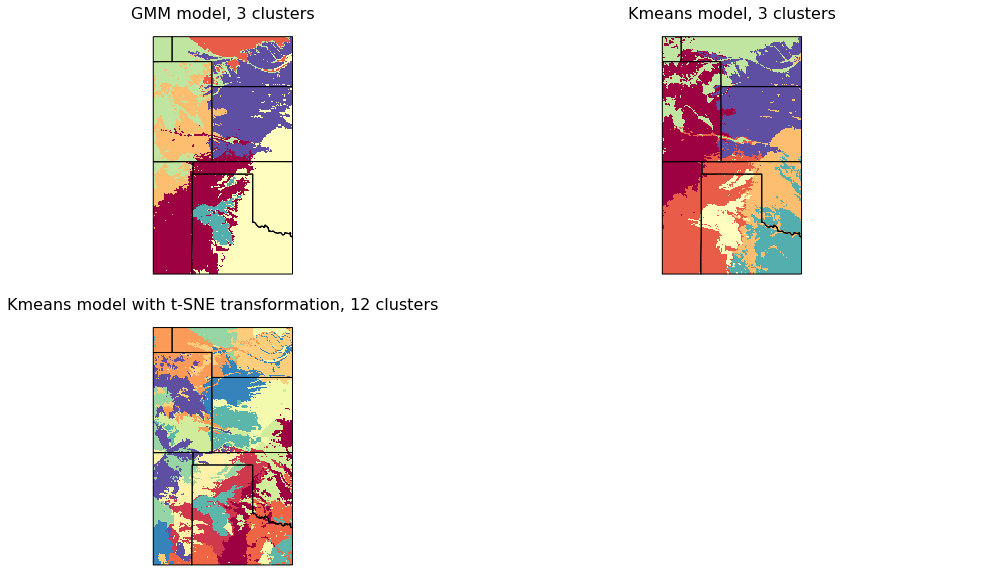

In [34]:
fig, axs = plt.subplots(2,2, figsize=(14,8), constrained_layout=True) 

# First Plot
plot = map_df.plot(column=map_df.gmm, 
            cmap= 'Spectral_r',  
            ax=axs[0,0], 
            ) 
axs[0,0].set_title('GMM model, 3 clusters', fontsize=16)

# Second Plot
plot = map_df.plot(column=map_df.kmeans, 
            cmap= 'Spectral_r',  
            ax=axs[0,1], 
            ) 
axs[0,1].set_title('Kmeans model, 3 clusters', fontsize=16)

# Third Plot
plot = map_df.plot(column=map_df.tsne_kmeans, 
            cmap= 'Spectral_r',  
            ax=axs[1,0], 
            ) 
axs[1,0].set_title('Kmeans model with t-SNE transformation, 12 clusters', fontsize=16)

# Fourth Plot
#plot = map_df.plot(column=map_df.mds_kmeans, 
#            cmap= 'Spectral_r',  
#            ax=axs[1,1], 
#            ) 
#axs[1,1].set_title('Kmeans model with MSD transformation, 5 clusters', fontsize=16)

axs[0,0].set_axis_off()
axs[0,1].set_axis_off()
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()

# Plot boundaries 
plains.plot(ax=axs[0,0], color='none', edgecolor='black')
plains.plot(ax=axs[0,1], color='none', edgecolor='black')
plains.plot(ax=axs[1,0], color='none', edgecolor='black')
#map_df.plot(ax=axs[1,1], color='none', edgecolor='black')

plt.show()

# Evaluate the features for the GMM and Kmeans Models with the PCA transformed data

In [80]:
kmeans_features = map_df.groupby(by='kmeans').agg({'vap_pres':["mean", "std"],'elevation':["mean", "std"], 'precip':["mean", "std"], 'gdu':["mean", "std"],'H20_capcity':["mean", "std"],'sand':["mean", "std"], 'clay':["mean", "std"], 'silt':["mean", "std"], 'depth':["mean", "std"]})
(unique, counts) = np.unique(kmean_cluster, return_counts=True)
frequencies = np.asarray((unique, counts)).T

silhouette_avg = silhouette_score(X, kmean_cluster, metric='sqeuclidean')
print('')
print('Kmean average silhouette score is', round(silhouette_avg,2))
print('')
print('Number of observations for each KMEANS cluster is')
print(frequencies)


Kmean average silhouette score is 0.64

Number of observations for each cluster is
[[   0 6010]
 [   1 4279]
 [   2 1901]]


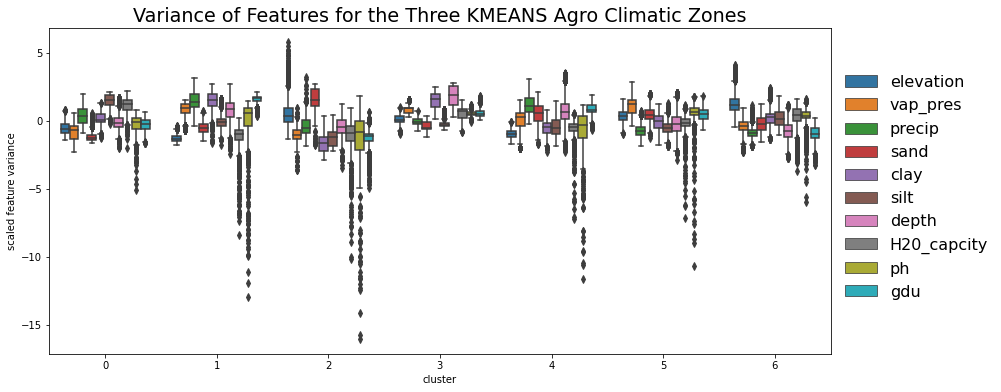

In [36]:
# Plot a Box Plot for each feature range in the Kmeans Model

# Process data by dropping variables, and then scaling features to present on a single graph
X = map_df.drop(columns=['gmm', 'kmeans', 'tsne_kmeans', 'geometry'])
names = X.columns
X=scaler.fit_transform(X)
X=pd.DataFrame(X, columns=names)
X['kmeans']=map_df['kmeans']

kmeans = pd.melt(X, id_vars='kmeans')

# Plots
fig = plt.subplots(figsize=(14,6))
plt.rcParams['font.size'] = 16
plot= sns.boxplot(x='kmeans', y='value',data=kmeans, hue='variable') 
plt.legend(frameon=False, bbox_to_anchor=(1, 0.9), ncol = 1)
plt.title('Variance of Features for the Three KMEANS Agro Climatic Zones')
plt.xlabel('cluster')
plt.ylabel('scaled feature variance')
plt.show()

In [37]:
# Summarize the features for GMM model
gmm_features = map_df.groupby(by='gmm').agg({'vap_pres':["mean", "std"],'elevation':["mean", "std"], 'precip':["mean", "std"], 'gdu':["mean", "std"],'H20_capcity':["mean", "std"],'sand':["mean", "std"], 'clay':["mean", "std"], 'silt':["mean", "std"], 'depth':["mean", "std"]})

(unique, counts) = np.unique(gmm_cluster, return_counts=True)
frequencies = np.asarray((unique, counts)).T

silhouette_avg = silhouette_score(X, gmm_cluster, metric='sqeuclidean')
print('')
print('GMM average silhouette score is', round(silhouette_avg,2))
print('')
print('Number of observations for each cluster is')
print(frequencies)


GMM average silhouette score is 0.34

Number of observations for each cluster is
[[   0 7231]
 [   1 1095]
 [   2 5431]
 [   3 9469]
 [   4 4591]
 [   5 1676]
 [   6 8257]]


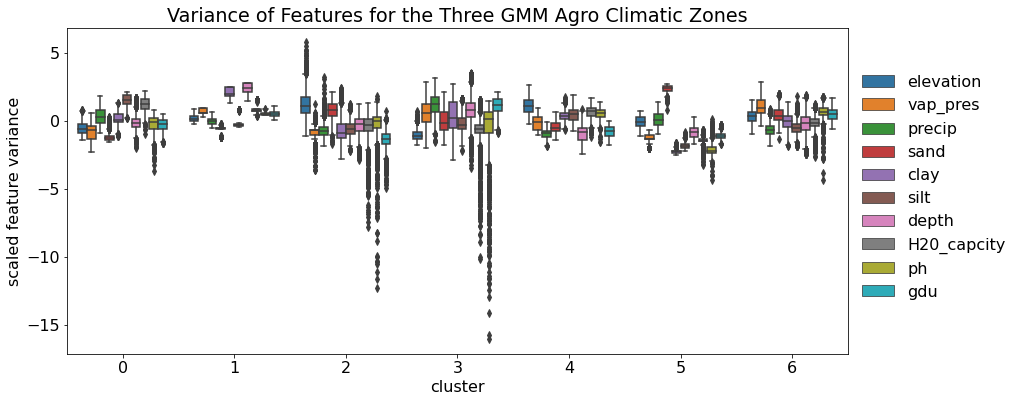

In [38]:
# Plot a Box Plot for each feature range in the GMM Model

# Process data by dropping variables, and then scaling features to present on a single graph
X = map_df.drop(columns=['gmm', 'kmeans', 'tsne_kmeans', 'geometry'])
names = X.columns
X=scaler.fit_transform(X)
X=pd.DataFrame(X, columns=names)
X['gmm']=map_df['gmm']

gmm = pd.melt(X, id_vars='gmm')

# Plots
fig = plt.subplots(figsize=(14,6))
plt.rcParams['font.size'] = 16
plot= sns.boxplot(x='gmm', y='value',data=gmm, hue='variable') 
plt.legend(frameon=False, bbox_to_anchor=(1, 0.9), ncol = 1)
plt.title('Variance of Features for the Three GMM Agro Climatic Zones')
plt.xlabel('cluster')
plt.ylabel('scaled feature variance')
plt.show()

# Citations 
PRISM Climate Group, Oregon State University. (1981-2010). 30-Year Normals United States Average Monthly Precipitation. http://prism.oregonstate.edu </br>
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. </br>
Soil Survey Staff, Natural Resources Conservation Service, United States Department of Agriculture. U.S. General Soil Map (STATSGO2). Available online at https://sdmdataaccess.sc.egov.usda.gov.</br>